In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import Delaunay, delaunay_plot_2d
from ellipse_packing import steiner_inellipse

In [2]:
Lx = 1.0
Ly = 1.0
n_elps = 16
seed = 8

In [3]:
from poisson_disc_sampling import poisson_disc_sampling as pds
L_m = 1.0
radius = 0.3

points = np.vstack(pds(radius, np.array([Lx*L_m,Ly*L_m]), sample_rejection_threshold=30))
points = points - np.ones(points.shape)*(L_m-1)/2

n_step = int(1/radius)+1
pfx = np.hstack((np.arange(n_step+1)/n_step,np.arange(n_step+1)/n_step,np.ones(n_step-1),np.zeros(n_step-1)))
pfy = np.hstack((np.ones(n_step+1),np.zeros(n_step+1),(np.arange(n_step-1)+1)/n_step,(np.arange(n_step-1)+1)/n_step))
pf = np.vstack((pfx,pfy)).T

(0, 1)

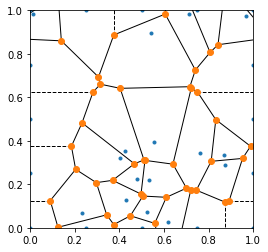

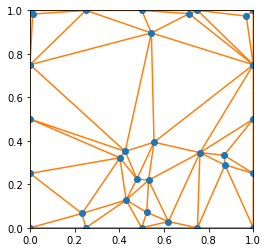

In [4]:
# randomly generate points 
np.random.seed(seed)
cx = Lx*np.random.rand(n_elps,1)
cy = Ly*np.random.rand(n_elps,1)
points = np.hstack((cx,cy))

pts = np.vstack((points,pf))

# pts = points
vor = Voronoi(pts)
tri = Delaunay(pts)

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
f = voronoi_plot_2d(vor, ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
f = delaunay_plot_2d(tri, ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)


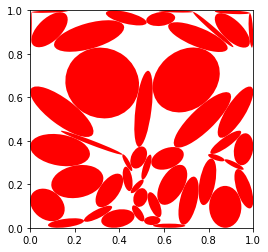

In [5]:
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)
for triang in tri.simplices:
    A = triang[0]
    B = triang[1]
    C = triang[2]
    vertices = np.array([pts[A], pts[B], pts[C]])
    centroid, semi_minor, semi_major, ang = steiner_inellipse(vertices)
    if np.any((vertices[:,0]<0,vertices[:,0]>1,vertices[:,1]<0,vertices[:,1]>1)):
        continue
    if semi_major/semi_minor<100:
        ellipse = Ellipse(centroid, 2*semi_major, 2*semi_minor, angle=ang,
                          facecolor="red")
        ax.add_artist(ellipse)
plt.show()

In [6]:
from fenics import *
from dolfin_adjoint import *
import pygmsh_mesh_functions
from pygmsh_mesh_functions import *
import meshio

Info    : Running '/home/fenics/.local/bin/gmsh -3 /tmp/tmp1i78rwk4.geo -format msh -bin -o /tmp/tmpf8xzmvaa.msh' [Gmsh 4.9.5, 1 node, max. 1 thread]
Info    : Started on Sun Apr 24 22:23:12 2022
Info    : Reading '/tmp/tmp1i78rwk4.geo'...
Info    : Done reading '/tmp/tmp1i78rwk4.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 556 (Ellipse)
Info    : [ 10%] Meshing curve 557 (Line)
Info    : [ 10%] Meshing curve 558 (Line)
Info    : [ 10%] Meshing curve 559 (Line)
Info    : [ 20%] Meshing curve 560 (Line)
Info    : [ 20%] Meshing curve 561 (Ellipse)
Info    : [ 20%] Meshing curve 562 (Ellipse)
Info    : [ 30%] Meshing curve 563 (Ellipse)
Info    : [ 30%] Meshing curve 564 (Ellipse)
Info    : [ 30%] Meshing curve 565 (Ellipse)
Info    : [ 30%] Meshing curve 566 (Ellipse)
Info    : [ 40%] Meshing curve 567 (Ellipse)
Info    : [ 40%] Meshing curve 568 (Ellipse)
Info    : [ 40%] Meshing curve 569 (Ellipse)
Info    : [ 50%] Meshing curve 570 (Ellipse)
Info    : [ 50%] Meshing cu

3447

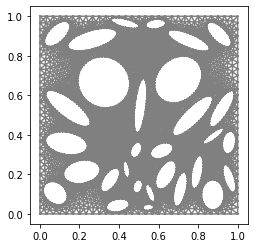

In [12]:
reset_geometry()

meshsize_min = 0.015
meshsize_max = 0.05

pygmsh_mesh_functions.hmeshmin = meshsize_min
pygmsh_mesh_functions.hmeshmax = meshsize_max

domain = add_polygon([(0, 0), (Lx, 0), (Lx, Ly), (0, Ly)])
for triang in tri.simplices:
    A = triang[0]
    B = triang[1]
    C = triang[2]
    vertices = np.array([pts[A], pts[B], pts[C]])
    if np.any((vertices[:,0]<0,vertices[:,0]>1,vertices[:,1]<0,vertices[:,1]>1)):
        continue
    centroid, semi_minor, semi_major, ang = steiner_inellipse(vertices)
    if semi_major/semi_minor<5 and semi_minor>0.02:
        ell = [add_ellipse(centroid, semi_major*0.8, semi_minor*0.8, angle=(ang)/180*np.pi)]
        domain = subtract(domain, ell)
    
#CREATE AND STORE MESH
sample_name = "midpoint_ellipse_rand_{:02d}.xdmf".format(seed)
out_dir = pathlib.Path("output_files")
out_dir.mkdir(parents=True, exist_ok=True)
mesh = create_fenics_mesh(mesh_path = out_dir / sample_name, verbose=True)
cell_type = mesh.cell_name()
with create_XDMFFile(out_dir / sample_name) as xf:
    xf.write(mesh)
    
plot(mesh)
len(mesh.coordinates())